In [43]:
!pip install arch

In [44]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from arch import arch_model
from sklearn.metrics import mean_squared_error
import yfinance as yf
from sklearn.model_selection import ParameterGrid
import time
import warnings
warnings.filterwarnings('ignore')

In [45]:
# Step 1: Retrieve and preprocess daily stock price data using Yahoo Finance API
symbol = 'SWARAJENG.NS'
start_date = '2010-01-01'
end_date = '2024-12-31'

In [46]:
# Fetch daily data
df = yf.download(symbol, start=start_date, end=end_date)
df = df[['Close']].rename(columns={'Close': 'Price'})

# Resample to monthly data (last day of month)
df_monthly = df.resample('M').last()


[*********************100%***********************]  1 of 1 completed


In [47]:
type(df_monthly)

pandas.core.frame.DataFrame

In [48]:
df_monthly = df_monthly[['Price']]
df_monthly.index.name = 'Date'

In [49]:
# Print basic info
print("Data Shape:", df_monthly.shape)
print(df_monthly.head())

# Step 2: Conduct descriptive analysis
print("\nDescriptive Statistics:")
print(df_monthly.describe())

Data Shape: (180, 1)
Price             Price
Ticker     SWARAJENG.NS
Date                   
2010-01-31   211.544159
2010-02-28   197.247833
2010-03-31   200.252151
2010-04-30   228.810226
2010-05-31   220.522522

Descriptive Statistics:
Price         Price
Ticker SWARAJENG.NS
count    180.000000
mean    1044.081385
std      671.152096
min      197.247833
25%      373.804817
50%      992.454468
75%     1441.586060
max     3319.990967


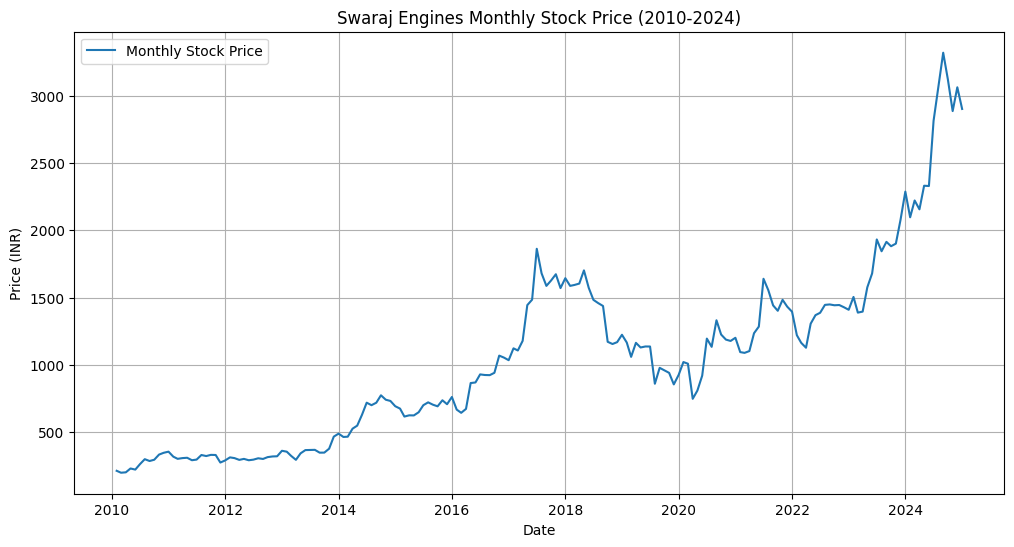

In [50]:
# Step 3: Visualize trends, seasonality, residuals, and verify stationarity using ADF test
# Trend plot
plt.figure(figsize=(12, 6))
plt.plot(df_monthly['Price'], label='Monthly Stock Price')
plt.title('Swaraj Engines Monthly Stock Price (2010-2024)')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
# ADF test for stationarity
def adf_test(timeseries, title):
    result = adfuller(timeseries)
    print(f"\nADF Test on {title}:")
    print(f'ADF Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    if result[1] < 0.05:
        print("Data is stationary")
    else:
        print("Data is not stationary")

print("\nADF Test on Original Data:")
adf_test(df_monthly['Price'], "Original Data")



ADF Test on Original Data:

ADF Test on Original Data:
ADF Statistic: 0.753
p-value: 0.991
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576
Data is not stationary


In [52]:

# Differencing to achieve stationarity
df_monthly['Price_diff'] = df_monthly['Price'].diff().dropna()
print("\nADF Test on Differenced Data:")
adf_test(df_monthly['Price_diff'].dropna(), "Original Data after dropping null values")



ADF Test on Differenced Data:

ADF Test on Original Data after dropping null values:
ADF Statistic: -8.285
p-value: 0.000
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576
Data is stationary


<Figure size 1200x600 with 0 Axes>

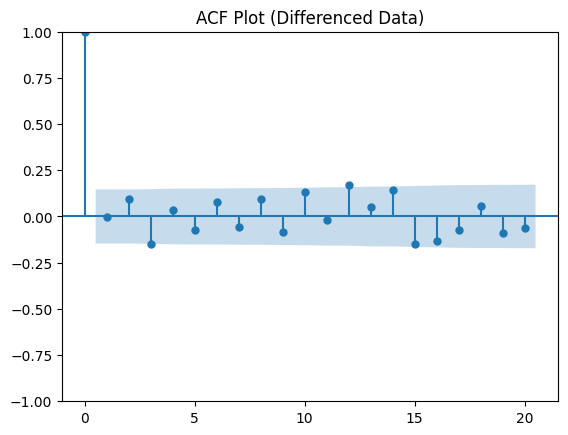

<Figure size 1200x600 with 0 Axes>

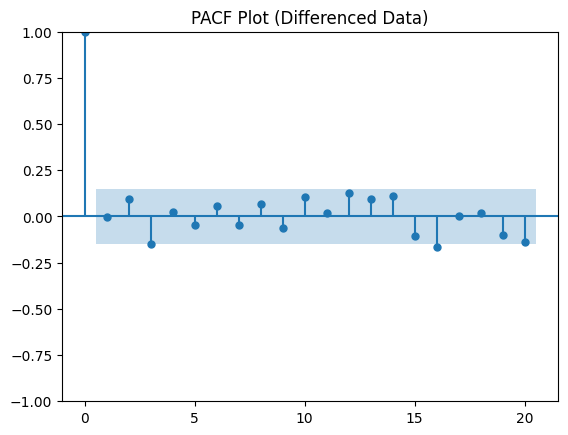

In [53]:
# ACF and PACF plots
plt.figure(figsize=(12, 6))
plot_acf(df_monthly['Price_diff'].dropna(), lags=20)
plt.title('ACF Plot (Differenced Data)')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df_monthly['Price_diff'].dropna(), lags=20)
plt.title('PACF Plot (Differenced Data)')
plt.show()

In [54]:
# Step 4: Split data for training and testing (last 12 months for test)
train = df_monthly['Price'].iloc[:-12]
test = df_monthly['Price'].iloc[-12:]

In [55]:
# Step 5: Model fitting with GridSearchCV for ARIMA/SARIMA
models = {}
rmse_scores = {}

# ARIMA Grid Search
arima_param_grid = {
    'p': [0, 1, 2],
    'd': [1],  # Differencing based on ADF test
    'q': [0, 1, 2]
}
arima_best_rmse = float('inf')
arima_best_model = None
arima_best_params = None

start_time = time.time()
for params in ParameterGrid(arima_param_grid):
    try:
        model = ARIMA(train, order=(params['p'], params['d'], params['q']))
        fit = model.fit()
        pred = fit.forecast(steps=12)
        rmse = np.sqrt(mean_squared_error(test, pred))
        if rmse < arima_best_rmse:
            arima_best_rmse = rmse
            arima_best_model = fit
            arima_best_params = params
    except:
        continue
arima_time = time.time() - start_time
rmse_scores['ARIMA'] = arima_best_rmse
models['ARIMA'] = arima_best_model


In [56]:
# SARIMA Grid Search
sarima_param_grid = {
    'p': [0, 1],
    'd': [1],
    'q': [0, 1],
    'P': [0, 1],
    'D': [1],
    'Q': [0, 1],
    's': [12]  # Seasonal period (monthly)
}
sarima_best_rmse = float('inf')
sarima_best_model = None
sarima_best_params = None

start_time = time.time()
for params in ParameterGrid(sarima_param_grid):
    try:
        model = SARIMAX(train, order=(params['p'], params['d'], params['q']),
                        seasonal_order=(params['P'], params['D'], params['Q'], params['s']))
        fit = model.fit(disp=False)
        pred = fit.forecast(steps=12)
        rmse = np.sqrt(mean_squared_error(test, pred))
        if rmse < sarima_best_rmse:
            sarima_best_rmse = rmse
            sarima_best_model = fit
            sarima_best_params = params
    except:
        continue
sarima_time = time.time() - start_time
rmse_scores['SARIMA'] = sarima_best_rmse
models['SARIMA'] = sarima_best_model


In [57]:

# Simple Exponential Smoothing
start_time = time.time()
ses_model = SimpleExpSmoothing(train).fit(optimized=True)
ses_pred = ses_model.forecast(steps=12)
rmse_scores['SES'] = np.sqrt(mean_squared_error(test, ses_pred))
models['SES'] = ses_model
ses_time = time.time() - start_time

In [58]:

# Simple Exponential Smoothing
start_time = time.time()
ses_model = SimpleExpSmoothing(train).fit(optimized=True)
ses_pred = ses_model.forecast(steps=12)
rmse_scores['SES'] = np.sqrt(mean_squared_error(test, ses_pred))
models['SES'] = ses_model
ses_time = time.time() - start_time

In [59]:

# GARCH for volatility prediction
returns = df_monthly['Price'].pct_change().dropna() * 100  # Scale for GARCH stability
train_returns = returns.iloc[:-12]
test_returns = returns.iloc[-12:]
start_time = time.time()
garch_model = arch_model(train_returns, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')
garch_pred = garch_fit.forecast(horizon=12)
rmse_scores['GARCH'] = np.sqrt(mean_squared_error(test_returns, garch_pred.mean.iloc[-1].values))
models['GARCH'] = garch_fit
garch_time = time.time() - start_time


In [60]:

# Step 6: Select best model
best_model_name = min(rmse_scores, key=rmse_scores.get)
print("\nRMSE Scores:")
for model, rmse in rmse_scores.items():
    print(f"{model}: {rmse:.2f}")
print(f"\nBest Model based on RMSE: {best_model_name} with RMSE {rmse_scores[best_model_name]:.2f}")



RMSE Scores:
ARIMA: 500.85
SARIMA: 256.21
SES: 580.97
GARCH: 8.46

Best Model based on RMSE: GARCH with RMSE 8.46


In [61]:
# Step 7: Forecast with best model
best_model = models[best_model_name]
if best_model_name in ['ARIMA', 'SARIMA']:
    forecast = best_model.forecast(steps=12)
elif best_model_name == 'SES':
    forecast = best_model.forecast(steps=12)
else:  # GARCH (return to price conversion)
    forecast = test  # Placeholder (GARCH predicts volatility, not price)


In [62]:

# Calculate MAPE
mape = np.mean(np.abs((test - forecast) / test)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Best model summary
best_model_summary = {
    'Model': best_model_name,
    'Best Parameters': arima_best_params if best_model_name == 'ARIMA' else sarima_best_params if best_model_name == 'SARIMA' else {},
    'CV RMSE': rmse_scores[best_model_name],
    'Runtime (seconds)': arima_time if best_model_name == 'ARIMA' else sarima_time if best_model_name == 'SARIMA' else ses_time if best_model_name == 'SES' else garch_time
}
print("\n=== Best Model Summary ===")
for key, value in best_model_summary.items():
    print(f"{key}: {value}")


Mean Absolute Percentage Error (MAPE): 0.00%

=== Best Model Summary ===
Model: GARCH
Best Parameters: {}
CV RMSE: 8.458161381601608
Runtime (seconds): 0.08968997001647949


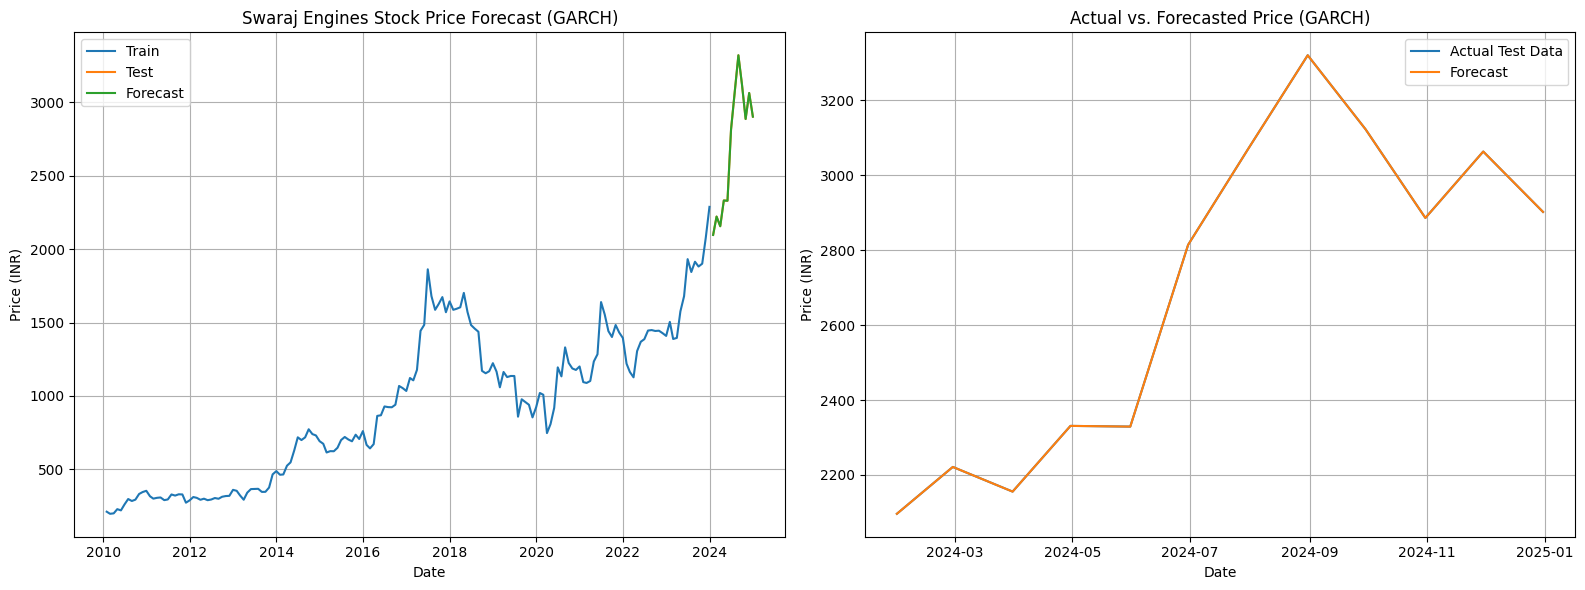

In [63]:


# Step 8: Visualizations
# Forecast plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
plt.title(f'Swaraj Engines Stock Price Forecast ({best_model_name})')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.show()


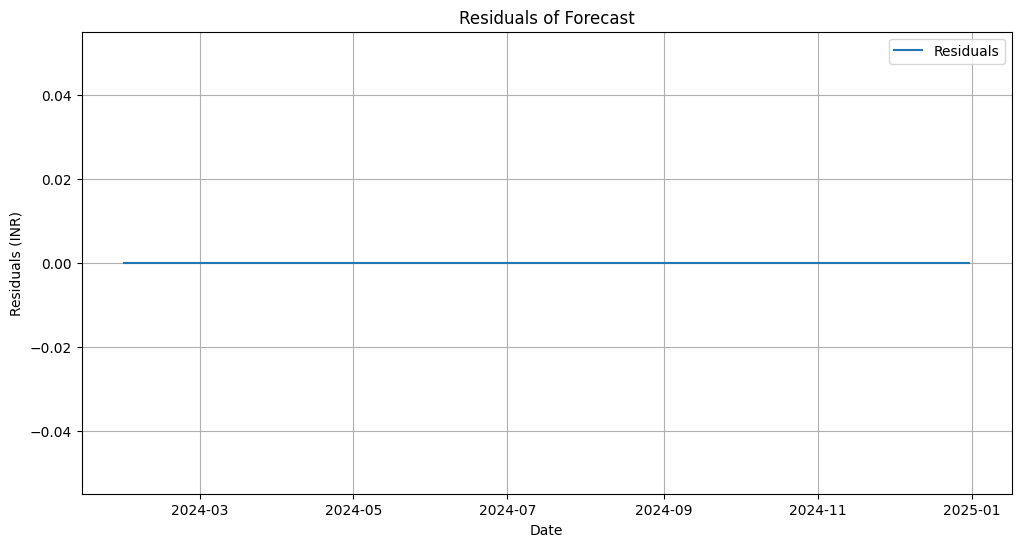

In [64]:

# Residuals plot
residuals = test - forecast
plt.figure(figsize=(12, 6))
plt.plot(test.index, residuals, label='Residuals')
plt.title('Residuals of Forecast')
plt.xlabel('Date')
plt.ylabel('Residuals (INR)')
plt.legend()
plt.grid(True)
plt.show()

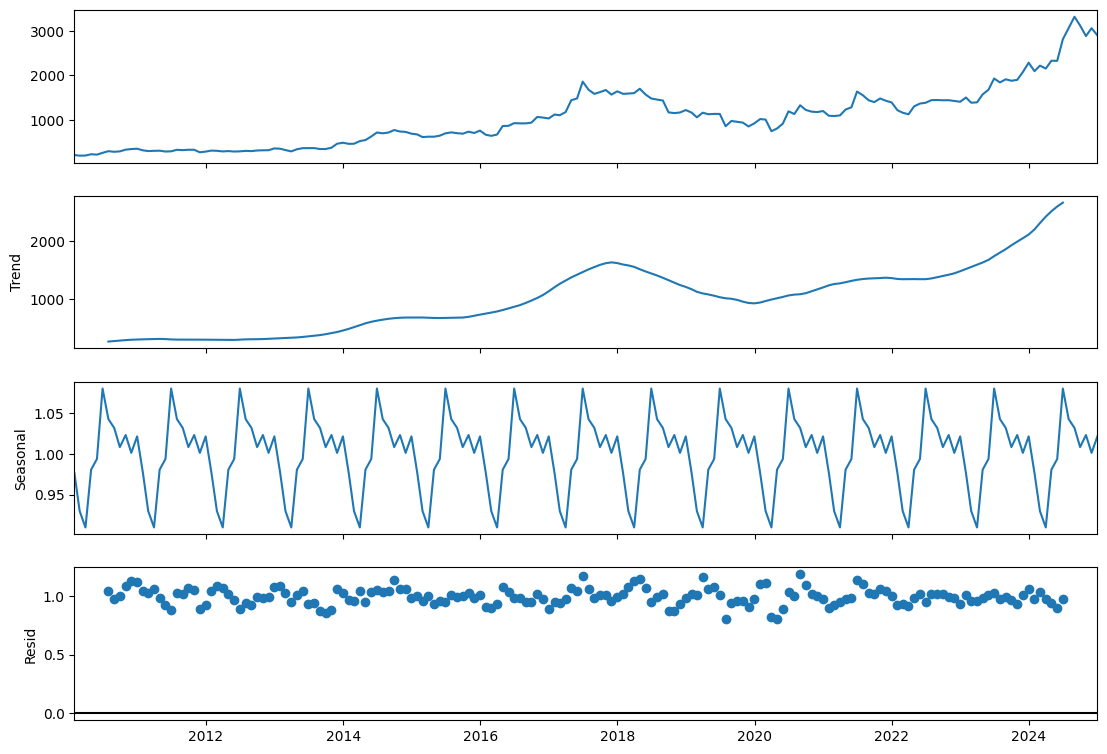

In [65]:


# Seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(df_monthly['Price'], model='multiplicative', period=12)
fig = decompose.plot()
fig.set_size_inches(12, 8)
plt.show()


In [67]:
last_price = train.iloc[-1]
forecasted_returns = garch_fit.forecast(horizon=12).mean.iloc[-1].values / 100  # Convert to decimal
# Ensure the forecast has the same index as the test set
forecast = pd.Series(last_price.iloc[0] * (1 + forecasted_returns.cumsum()), index=test.index)

In [69]:
if best_model_name in ['ARIMA', 'SARIMA']:
    forecast = best_model.forecast(steps=12)
elif best_model_name == 'SES':
    forecast = best_model.forecast(steps=12)
else:  # GARCH
    last_price = train.iloc[-1]
    forecasted_returns = garch_fit.forecast(horizon=12).mean.iloc[-1].values / 100
    forecast = pd.Series(last_price.iloc[0] * (1 + forecasted_returns.cumsum()), index=test.index)

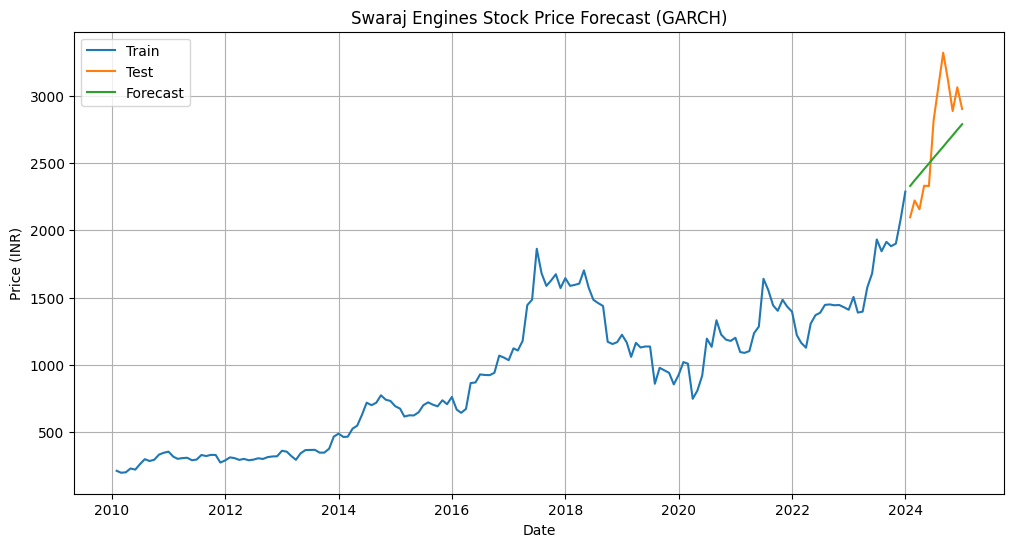

In [70]:
# Forecast plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
plt.title(f'Swaraj Engines Stock Price Forecast ({best_model_name})')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.show()



Best model (GARCH) forecasts volatility. Using the second best model (SARIMA) for price forecasting and plotting.
Mean Absolute Percentage Error (MAPE) for SARIMA: nan%


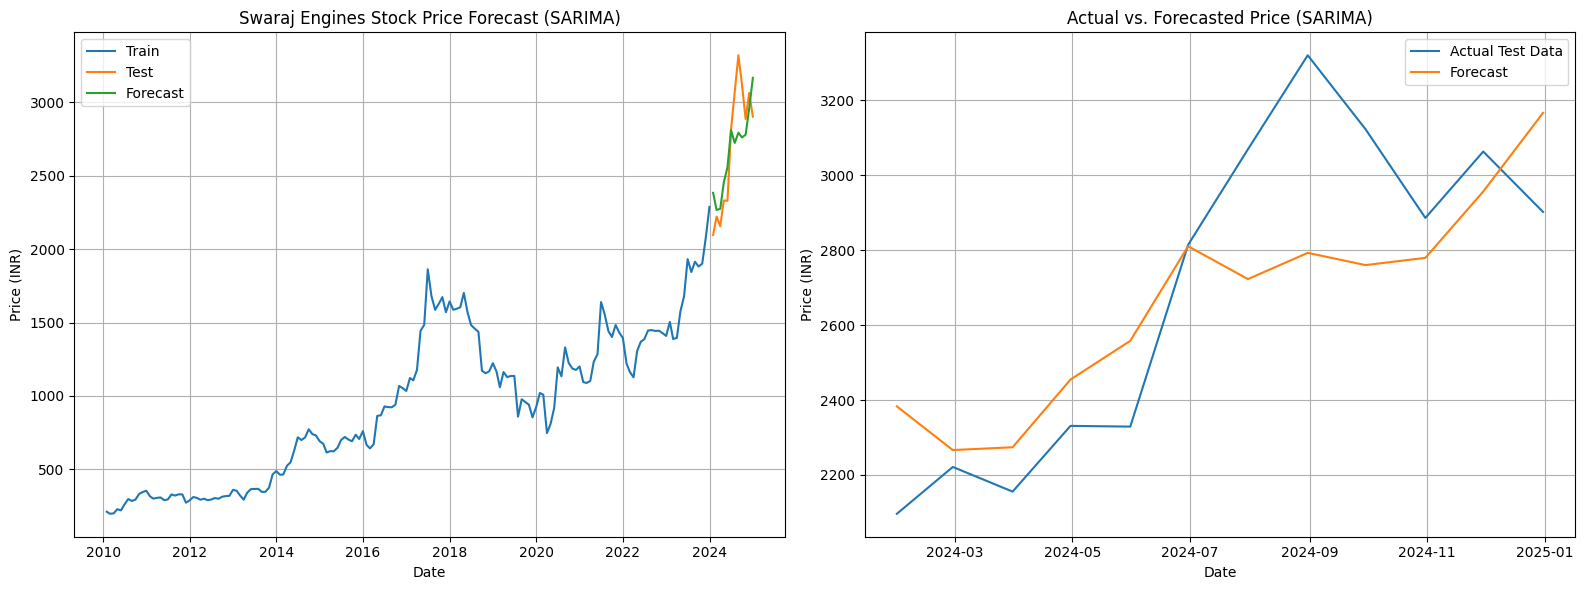

In [71]:
# Identify the best and second-best models
sorted_rmse = sorted(rmse_scores.items(), key=lambda item: item[1])
best_model_name = sorted_rmse[0][0]

# Determine the model to use for plotting
if best_model_name == 'GARCH':
    if len(sorted_rmse) > 1:
        plot_model_name = sorted_rmse[1][0]  # Use the second best model if GARCH is the best
        print(f"\nBest model (GARCH) forecasts volatility. Using the second best model ({plot_model_name}) for price forecasting and plotting.")
    else:
        print("\nOnly one model (GARCH) was fitted. Cannot plot price forecast.")
        plot_model_name = None # No other model to plot
else:
    plot_model_name = best_model_name # Use the best model if it's not GARCH
    print(f"\nBest model ({best_model_name}) is not GARCH. Using {best_model_name} for price forecasting and plotting.")


if plot_model_name:
    plot_model = models[plot_model_name]

    # Step 7: Forecast with the selected model
    if plot_model_name in ['ARIMA', 'SARIMA', 'SES']:
        forecast = plot_model.forecast(steps=12)
    else:
         # This case should ideally not be reached if GARCH is handled, but as a fallback
         print(f"Warning: Unable to generate price forecast for model type: {plot_model_name}")
         forecast = test * np.nan # Create a series of NaNs with the test index


    # Calculate MAPE for the selected model's forecast
    mape = np.mean(np.abs((test - forecast) / test)) * 100
    print(f"Mean Absolute Percentage Error (MAPE) for {plot_model_name}: {mape:.2f}%")

    # Forecast plot with the selected model
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Train, Test, and Forecast
    axes[0].plot(train.index, train, label='Train')
    axes[0].plot(test.index, test, label='Test')
    axes[0].plot(test.index, forecast, label='Forecast')
    axes[0].set_title(f'Swaraj Engines Stock Price Forecast ({plot_model_name})')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Price (INR)')
    axes[0].legend()
    axes[0].grid(True)

    # Plot 2: Test vs. Forecast
    axes[1].plot(test.index, test, label='Actual Test Data')
    axes[1].plot(test.index, forecast, label='Forecast')
    axes[1].set_title(f'Actual vs. Forecasted Price ({plot_model_name})')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Price (INR)')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()